# Just Euler's method

$$
\newcommand{\dt}{\Delta t}
\newcommand{\ydt}[1]{y^{({#1})}(X)}
\newcommand{\Edt}[1]{E^{({#1})}}
\newcommand{\yone}[1]{y_{1}^{({#1})}}
$$

In the previous cases we've focused on the *behaviour* of the algorithm: whether it will give the correct answer in the limit, or whether it converges as expected.  This is really what you want to do: you're trying to do science, to get an answer, and so implementing the precise algorithm should be secondary.  If you are trying to implement a precise algorithm, it should be because of its (expected) behaviour, and so you should be testing for that!

However, let's put that aside and see if we can work out how to test whether we've implemented exactly the algorithm we want: Euler's method. Checking convergence alone is not enough: the [Backwards Euler method](http://en.wikipedia.org/wiki/Backward_Euler_method) has identical convergence behaviour, as do whole families of other methods. We need a check that characterizes the method uniquely.

The *local truncation error* $\Edt{\dt}$ would be exactly such a check. This is the error produced by a single step from exact data, eg

$$
\begin{equation}
  \Edt{\dt} = y_1 - y(\dt).
\end{equation}
$$

For Euler's method we have

$$
\begin{equation}
  y_{n+1} = y_n + \dt f(t_n, y_n)
\end{equation}
$$

and so


$$
\begin{equation}
  \Edt{\dt} = \left| y_0 + \dt f(0, y_0) - y(\dt) \right| =  \left| \frac{\dt^2}{2} \left. y''\right|_{t=0} \right| + {\cal O}(\dt^3).
\end{equation}
$$


This is all well and good, but we don't know the exact solution (in principle) at any point other than $t=0$, so cannot compute $y(\dt)$, so cannot compute $\Edt{\dt}$. We only know $\yone{\dt}$ for whichever values of $\dt$ we wish to compute.

We can use repeated Richardson extrapolation to get the solution $y(\dt)$ to sufficient accuracy, however. On the *assumption* that the algorithm is first order (we can use the previous techniques to check this), we can use Richardson extrapolation to repeatedly remove the highest order error terms. We can thus find the local truncation errors.

In [101]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [102]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 30.0   # trim velocity in m s^{-1}   
C_D = 1/40.  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = v_t     # start at the trim velocity (or add a delta)
theta0 = 0.0 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 1000.0  # initial altitude

In [103]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [104]:
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

In [105]:
T_values = numpy.array([0.001*2**(i) for i in range(10)])
lte_values = numpy.zeros_like(T_values)
for j, T in enumerate(T_values):
    dt_values = numpy.array([T*2**(i-8) for i in range(8)])
    v_values = numpy.zeros_like(dt_values)
    for i, dt in enumerate(dt_values):
        N = int(T/dt)+1
        t = numpy.linspace(0.0, T, N)
        u = numpy.empty((N, 4))
        u[0] = numpy.array([v0, theta0, x0, y0])
        for n in range(N-1):
            u[n+1] = euler_step(u[n], f, dt)
        v_values[i] = u[-1,0]
    v_next = v_values
    for s in range(1, len(v_values-1)):
        v_next = (2**s*v_next[1:]-v_next[0:-1])/(2**s-1)
    lte_values[j] = abs(v_values[0]-v_next)

In [106]:
lte_values

array([  1.99954897e-09,   8.05573563e-09,   3.26825287e-08,
         1.34407252e-07,   5.67045063e-07,   2.50349015e-06,
         1.18961299e-05,   6.26360623e-05,   3.70836832e-04,
         2.44291651e-03])

We now have four values for the local truncation error. We can thus compute the convergence rate of the local truncation error itself (which should be two), and check that it is close enough to the expected value using the previous techniques:

In [107]:
s_m = numpy.zeros(2)
for i in range(2):
    s_m[i] = log(abs((lte_values[2+i]-lte_values[1+i])/
                     (lte_values[1+i]-lte_values[0+i]))) / log(2.0)
    print("Measured convergence rate (base dt {}) is {:.6g} (error is {:.4g}).".format(
            T_values[i], s_m[i], abs(s_m[i]-2)))
print("Convergence error has reduced by factor {:.4g}.".format(
        abs(s_m[0]-2)/abs(s_m[1]-2)))

Measured convergence rate (base dt 0.001) is 2.02375 (error is 0.02375).
Measured convergence rate (base dt 0.002) is 2.04637 (error is 0.04637).
Convergence error has reduced by factor 0.5121.


So the error has gone down considerably, and certainly $0.51 < 2/3$, so the convergence rate of the local truncation error is close enough to 2.

However, that alone isn't enough to determine that this really is Euler's method: as noted above, the convergence rate of the local truncation error isn't the key point: the key point is that we can predict its *actual value* as

$$
\begin{equation}
  \Edt{\dt} =  \frac{\dt^2}{2} \left| \left. y''\right|_{t=0} \right| + {\cal O}(\dt^3) = \frac{\dt^2}{2} \left| \left( \left. \frac{\partial f}{\partial t} \right|_{t=0} + f(0, y_0) \left. \frac{\partial f}{\partial y} \right|_{t=0, y=y_0} \right) \right|.
\end{equation}
$$

For the specific problem considered here we have

$$
\begin{equation}
  y = \begin{pmatrix} v \\ \theta \\ x \\ y \end{pmatrix}, \quad f = \begin{pmatrix} -g\sin \theta - \frac{C_D}{C_L} \frac{g}{v_t^2} v^2 \\ -\frac{g}{v}\cos \theta + \frac{g}{v_t^2} v \\ v \cos \theta \\ v \sin \theta \end{pmatrix}.
\end{equation}
$$

We note that $f$ does not explicitly depend on $t$ (so $\partial f / \partial t \equiv 0$), and that the values of the parameters $g, C_D, C_L$ and $v_t$ are given above, along with the initial data $y_0 = (v_0, \theta_0, x_0, y_0)$.

So, let's find what the local truncation error should be.

In [108]:
import sympy
sympy.init_printing()
v, theta, x, y, g, CD, CL, vt, dt = sympy.symbols('v, theta, x, y, g, C_D, C_L, v_t, {\Delta}t')
u = sympy.Matrix([v, theta, x, y])
f = sympy.Matrix([-g*sympy.sin(theta)-CD/CL*g/vt**2*v**2, 
                  -g/v*sympy.cos(theta)+g/vt**2*v, 
                  v*sympy.cos(theta), 
                  v*sympy.sin(theta)])
dfdu = f.jacobian(u)
lte=dt**2/2*dfdu*f

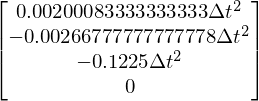

In [109]:
lte_0=lte.subs([(g,9.8),(vt,30.0),(CD,1.0/40.0),(CL,1.0),(v,30.0),(theta,0.0),(x,0.0),(y,1000.0)])
lte_0

So let us check the local truncation error values, which are computed for `v`:

In [114]:
lte_values/T_values**2

array([ 0.00199955,  0.00201393,  0.00204266,  0.00210011,  0.00221502,
        0.00244481,  0.00290433,  0.003823  ,  0.00565852,  0.00931899])

These are indeed converging towards $0.002 \dt^2$ as they should. To check this quantitatively, we use that our model is

$$
\begin{equation}
  \Edt{\dt} = \alpha \dt^2 + {\cal O}(\dt^3),
\end{equation}
$$

with the exact value $\alpha_e \simeq 0.002$. So we can use our usual Richardson extrapolation methods applied to $\Edt{\dt}/\dt^2$, to get a measured value for $\alpha$ with an error interval:

$$
\begin{equation}
  \alpha_m  = \frac{8\Edt{\dt} - \Edt{2\dt} \pm \left| \Edt{\dt} - \Edt{2\dt} \right|}{4\dt^2}.
\end{equation}
$$

In [113]:
for i in range(len(lte_values)-1):
    Edt = lte_values[i]
    E2dt = lte_values[i+1]
    dt = T_values[i]
    err1 = abs(Edt - E2dt)
    a_lo = (8.0*Edt - E2dt - err1)/(4.0*dt**2)
    a_hi = (8.0*Edt - E2dt + err1)/(4.0*dt**2)
    print("Base dt={:.4g}: the measured alpha is in [{:.5g}, {:.5g}]".format(
            dt, a_lo, a_hi))
    print("Does this contain the exact value? {}".format(
            a_lo <= lte_exact <= a_hi))

Base dt=0.001: the measured alpha is in [0.00047112, 0.0034992]
Does this contain the exact value? True
Base dt=0.002: the measured alpha is in [0.00044604, 0.0035244]
Does this contain the exact value? True
Base dt=0.004: the measured alpha is in [0.00039575, 0.0035747]
Does this contain the exact value? True
Base dt=0.008: the measured alpha is in [0.00029522, 0.0036752]
Does this contain the exact value? True
Base dt=0.016: the measured alpha is in [9.4165e-05, 0.0038763]
Does this contain the exact value? True
Base dt=0.032: the measured alpha is in [-0.00030782, 0.0042784]
Does this contain the exact value? True
Base dt=0.064: the measured alpha is in [-0.0011113, 0.0050826]
Does this contain the exact value? True
Base dt=0.128: the measured alpha is in [-0.0027153, 0.0066903]
Does this contain the exact value? True
Base dt=0.256: the measured alpha is in [-0.0059063, 0.0099024]
Does this contain the exact value? True


So, to the limits that we can measure the local truncation error, we have implemented Euler's method.